# [GluonCV — 计算机视觉的深度学习工具包](https://zh.mxnet.io/blog/gluon-cv)

# GitHub：[GluonCV: a Deep Learning Toolkit for Computer Vision](http://gluon-cv.mxnet.io/)

In [2]:
import sys 

sys.path.append('E:/xinlib')
import xintcv
from xintcv import Cifar10

from mxnet import gluon, nd, image

import mxnet as mx
import numpy as np

import matplotlib.pyplot as plt
import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv import utils
from gluoncv.utils import makedirs, TrainingHistory

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


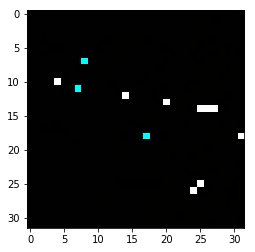

In [2]:
%pylab inline
url = 'https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/plane-draw.jpeg'
im_fname = utils.download(url, path='E:/Data/MXNet')
img = image.imread(im_fname)
D = xintcv.LoaderCV()
x = D.plot_image(img)

[Epoch 0] train=0.363482 val=0.455400 loss=85956.182983 time: 414.442617
[Epoch 1] train=0.509115 val=0.564200 loss=68426.486328 time: 414.310274


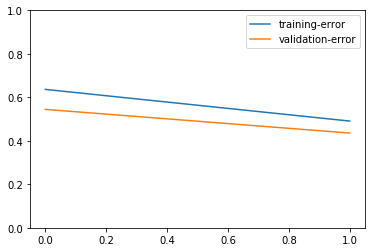

In [5]:
d = xintcv.Cifar10()
d.train(2)

In [3]:
class Cifar(Cifar10):
    '''
    使用 mxboard 的可视化效果
    `tensorboard --logdir=D:/logs --host=127.0.0.1 --port=8889`
    '''
    def __init__(self, net):
        super().__init__()
        self.dataDtype = name
        self.logdir = 'D:/logs'
        self.log_interval = 200

    def loader(self):
        '''
        初始化模型并为训练和验证数据集定义数据装载器
        '''  
        # Batch Size for Each GPU
        per_device_batch_size = 128
        # Number of data loader workers
        num_workers = 0   # Windows  系统不支持大于 `0`
        # Calculate effective total batch size
        batch_size = per_device_batch_size * self.num_gpus

        # Set train=True for training data
        # Set shuffle=True to shuffle the training data
        train_data = gluon.data.DataLoader(
            gluon.data.vision.CIFAR10(
                train=True).transform_first(self.transform_train),
            batch_size=batch_size,
            shuffle=True,
            last_batch='discard',
            num_workers=num_workers)

        # Set train=False for validation data
        val_data = gluon.data.DataLoader(
            gluon.data.vision.CIFAR10(
                train=False).transform_first(self.transform_test),
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers)
        return batch_size, train_data, val_data

    def train_op(self):

        # Nesterov accelerated gradient descent
        optimizer = 'nag'
        # Set parameters
        optimizer_params = {
            'learning_rate': 0.1,
            'wd': 0.0001,
            'momentum': 0.9
        }

        # Define our trainer for net
        trainer = gluon.Trainer(self.net.collect_params(), optimizer,
                                optimizer_params)
        return trainer

    def test(self, ctx, val_data):
        '''
        验证数据集为我们提供了一种监视培训过程的方法。
        我们有验证数据的标签, 但它们在培训过程中被保留。
        相反, 我们使用它们来评估不可见数据的模型性能并防止 overfitting。
        '''
        metric = mx.metric.Accuracy()
        for i, batch in enumerate(val_data):
            data = gluon.utils.split_and_load(
                batch[0], ctx_list=ctx, batch_axis=0)
            label = gluon.utils.split_and_load(
                batch[1], ctx_list=ctx, batch_axis=0)
            outputs = [self.net(X) for X in data]
            metric.update(label, outputs)
        return metric.get()

    def train(self, epochs = 240):
        metric = mx.metric.Accuracy()
        sw = SummaryWriter(self.logdir, flush_secs=20)
        self.net.initialize(ctx=self.ctx, init=mx.init.MSRAPrelu(), force_reinit=True)
        self.net.hybridize()
        logging.basicConfig(level=logging.DEBUG)
        trainer = gluon.Trainer(self.net.collect_params(), 'rmsprop', {'learning_rate': 0.1, 'gamma1': 0.9})
        batch_size, train_data, val_data = self.init_op()
        
        # Learning rate decay
        lr_decay_count = 0
        # Learning rate decay factor
        lr_decay = 0.1
        # Epochs where learning rate decays
        lr_decay_epoch = [80, 160, np.inf]
        for epoch in range(epochs):
            tic = time.time()
            train_metric.reset()
            train_loss = 0

            if epoch == lr_decay_epoch[lr_decay_count]:
                trainer.set_learning_rate(trainer.learning_rate * lr_decay)
                lr_decay_count += 1

            # Loop through each batch of training data
            for i, batch in enumerate(train_data):
                # Extract data and label
                data = gluon.utils.split_and_load(
                    batch[0], ctx_list=self.ctx, batch_axis=0)
                label = gluon.utils.split_and_load(
                    batch[1], ctx_list=self.ctx, batch_axis=0)

                # AutoGrad
                with ag.record():
                    output = [self.net(X) for X in data]
                    loss = [self.loss_fn(yhat, y) for yhat, y in zip(output, label)]

                # Backpropagation
                for l in loss:
                    l.backward()

                # Optimize
                trainer.step(batch_size)

                # Update metrics
                train_loss += sum([l.sum().asscalar() for l in loss])
                train_metric.update(label, output)

            name, acc = train_metric.get()
            # Evaluate on Validation data
            name, val_acc = self.test(self.ctx, val_data)

            # print metrics
            print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
                  (epoch, acc, val_acc, train_loss, time.time() - tic))